# Yelp Data Challenge - Restaurant Recommender

# Main Tasks
1. Dataset
2. Clean data and get rating data
3. Select target users
4. Create utility matrix from records
5. Build restaurant recommender systems
    - 5.1 Item-Item similarity recommender
    - 5.2 Matrix Factorization recommender: NMF
        - 5.2.1 Matrix Reconstruction error - NMF
        - 5.2.2 Recommendation - NMF
    - 5.3 Matrix Factorization recommender: UVD
        - 5.3.1 Matrix Reconstruction Error - UVD
6. Other recommenders

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

## 1. Dataset

In [2]:
df = pd.read_csv('./dataset/last_2_years_restaurant_reviews.csv')

In [3]:
df.head()

,business_id,name,categories,avg_stars,cool,funny,review_id,stars,text,useful,user_id,count,text_length
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,6SgvNWJltnZhW7duJgZ42w,5,This is mine and my fiancé's favorite steakhou...,0,oFyOUOeGTRZhFPF9uTqrTQ,1,341
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,iwx6s6yQxc7yjS7NFANZig,4,Nice atmosphere and wonderful service. I had t...,0,2aeNFntqY2QDZLADNo8iQQ,1,417
2,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,UVUMu_bELdA56Ryfbur-DA,5,Every year a group of us (we had 6 this year) ...,1,gmPP4YFrgYsYQqPYokMgFA,1,493
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,UxFpgng8dPMWOj99653k5Q,5,Truly Fantastic! Best Steak ever. Service was...,0,aVOGlN9fZ-BXcbtj6dbf0g,1,152
4,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,"['Cajun/Creole', 'Steakhouses', 'Restaurants']",4.0,0,0,Xp3ppynEvVu1KxDHQ3ae8w,5,Delmonico Steakhouse is a steakhouse owned by ...,0,KC8H7qTZVPIEnanw9fG43g,1,914


## 2. Clean data and get rating data 

In [4]:
# Select relevant columns in the original dataframe
# Get business_id, user_id, stars for the recommender
selected_df = df[['business_id', 'user_id', 'stars']]

print(selected_df.shape)
selected_df.head()

(515752, 3)


,business_id,user_id,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,oFyOUOeGTRZhFPF9uTqrTQ,5
1,--9e1ONYQuAa-CB_Rrw7Tw,2aeNFntqY2QDZLADNo8iQQ,4
2,--9e1ONYQuAa-CB_Rrw7Tw,gmPP4YFrgYsYQqPYokMgFA,5
3,--9e1ONYQuAa-CB_Rrw7Tw,aVOGlN9fZ-BXcbtj6dbf0g,5
4,--9e1ONYQuAa-CB_Rrw7Tw,KC8H7qTZVPIEnanw9fG43g,5


In [5]:
# In total, 227241 users we have
print(len(selected_df.user_id.unique()))

# In total, 4832 restaurants we have
print(len(selected_df.business_id.unique()))

227241
4832


<Container object of 5 artists>

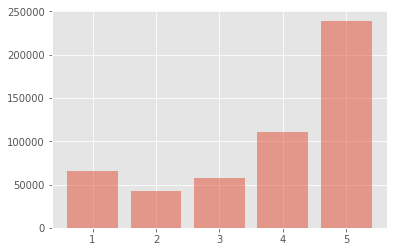

In [6]:
# Plot the star (rating) distribution using bar chart
# Most of users rated 4 or 5 stars to restaurants
plt.bar(selected_df.stars.value_counts().index, 
        selected_df.stars.value_counts().values, align='center', alpha=0.5)

## 3. Select target users

In [7]:
# 145721 users only had rated one restaurant 
# My goal at here is to select those users who rated more than three times
# Thus, the row dimension can be reduced
print(sum(selected_df.user_id.value_counts() == 1))
print(sum(selected_df.user_id.value_counts() == 2))
print(sum(selected_df.user_id.value_counts() == 3))

145721
36823
16398


In [8]:
selected_df.head()

,business_id,user_id,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,oFyOUOeGTRZhFPF9uTqrTQ,5
1,--9e1ONYQuAa-CB_Rrw7Tw,2aeNFntqY2QDZLADNo8iQQ,4
2,--9e1ONYQuAa-CB_Rrw7Tw,gmPP4YFrgYsYQqPYokMgFA,5
3,--9e1ONYQuAa-CB_Rrw7Tw,aVOGlN9fZ-BXcbtj6dbf0g,5
4,--9e1ONYQuAa-CB_Rrw7Tw,KC8H7qTZVPIEnanw9fG43g,5


#### How to filter user_id? 
- Steps:
    1. Count for each user_id appearance in the selected_df, and store the count result in a Series object (named user_count).
    2. Set a user_id as a new index in the selected_df for later extraction.
    3. Extract user_id in a stored Series object (user_count) who rated more than three times.
    4. Use the extracted user_id to perform a filtered selection on selected_df.
    5. Store the selection result in a dataframe (named filtered_df) and reset the index.

In [9]:
# Step 1
user_count = selected_df.user_id.value_counts()

In [10]:
user_count.head()

bLbSNkLggFnqwNNzzq-Ijw    748
JaqcCU3nxReTW2cBLHounA    330
PKEzKWv_FktMm2mGPjwd0Q    276
B1829_hxXSEpDPEDJtYeIw    244
U4INQZOPSUaj8hMjLlZ3KA    232
Name: user_id, dtype: int64

In [11]:
# Test whether it works
user_count[user_count > 3].index.values

array(['bLbSNkLggFnqwNNzzq-Ijw', 'JaqcCU3nxReTW2cBLHounA',
       'PKEzKWv_FktMm2mGPjwd0Q', ..., 'cE5v4kw8lv4N-el7BYafWA',
       'f2utO_Av2FFcXw9fzJGvKQ', '9-SlQK2lwcXVzk3tJU4x7g'], dtype=object)

In [12]:
# Step 2 
filtered_df = selected_df.set_index('user_id')

# Step 3 ~ 5
filtered_df = filtered_df.loc[user_count[user_count > 3].index.values].reset_index()

In [13]:
# Originally, 227241 users (now narrowed down to 28299 users)
print(len(filtered_df.user_id.unique()))

# 4631 restaurants I have
print(len(filtered_df.business_id.unique()))

# Make sure each user rated more than three times
print(min(filtered_df.user_id.value_counts()))

28299
4631
4


## 4. Create utility matrix from records

In [14]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from time import time

In [15]:
filtered_df.head()

,user_id,business_id,stars
0,bLbSNkLggFnqwNNzzq-Ijw,-BS4aZAQm9u41YnB9MUASA,4
1,bLbSNkLggFnqwNNzzq-Ijw,-C8sSrFqaCxp51pyo-fQLQ,4
2,bLbSNkLggFnqwNNzzq-Ijw,-CQokjildrY7UZezXCdEBw,5
3,bLbSNkLggFnqwNNzzq-Ijw,-FcZY7a7qgxTUlTvwuyJnQ,3
4,bLbSNkLggFnqwNNzzq-Ijw,-IWsoxH7mLJTTpU5MmWY4w,4


In [16]:
# The rows are users, the columns are restaurants, and the cells are stars (ratings)
# Cells are filled with 0 if no past rating existed
df_utility = pd.pivot_table(data=filtered_df, 
                            values='stars', 
                            index='user_id', 
                            columns='business_id', 
                            fill_value=0)

In [17]:
# 28299 users and 4631 restaurants
df_utility.shape

(28299, 4631)

In [18]:
df_utility.head()

business_id,--9e1ONYQuAa-CB_Rrw7Tw,-1m9o3vGRA8IBPNvNqKLmA,-1vfRrlnNnNJ5boOVghMPA,-3zffZUHoY8bQjGfPSoBKQ,-8R_-EkGpUhBk55K9Dd4mg,-9YyInW1wapzdNZrhQJ9dg,-AD5PiuJHgdUcAK-Vxao2A,-ADtl9bLp8wNqYX1k3KuxA,-BS4aZAQm9u41YnB9MUASA,-Bf8BQ3yMk8U2f45r2DRKw,...,zmltWmTpoBt5sCU-5Kzj-Q,znWHLW1pt19HzW1VY6KfCA,zp-K5s3pGTWuuaVBWo6WZA,zpoZ6WyQUYff18-z4ZU1mA,zrQ1zKWC-W2PCvwjBururQ,zsQk990PubOHjr1YcLkQFw,zt9RLUIU32fZYOBh2L0NNQ,zttcrQP4MxNS5X5itzStXg,zuwba6QEBIDZT0tJZmNhdQ,zwNC-Ow4eIMan2__bS9-rg
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--2vR0DIsmQ6WfcSzKWigw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--LUapetRSkZpFZ2d-MXLQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--RlSfc-QmcHFGHyX6aVjA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
--ZNfWKj1VyVElRx6-g1fg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0


## 5. Build restaurant recommender systems

### 5.1 Item-Item similarity recommender

In [19]:
# Turn a dataframe object into a matrix object first
# Then turn a matrix object into a sparse matrix object
ratings_mat = sparse.csr_matrix(df_utility.as_matrix())

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# Make sure the dimensions are both correct as before 
# 28299 users and 4631 restaurants
ratings_mat.shape

(28299, 4631)

#### Method (1) Didn't use ItemItemRecommender class 

In [21]:
# Transpose on ratings_mat to get item-item similarity
item_sim_mat = cosine_similarity(ratings_mat.T)

# check the item-item similarity matrix dimension
item_sim_mat.shape

(4631, 4631)

In [22]:
# Rank the column in each row (from the least to the most similar)
least_to_most_sim_indexes = np.argsort(item_sim_mat, axis=1)
print(least_to_most_sim_indexes.shape)

# Neighborhoods 
# Select the nearest 75 neighbors (75 restaurants) for each row
neighborhood_size = 75
neighborhoods = least_to_most_sim_indexes[:, -neighborhood_size:]

# for each restaurant, find 75 neighbors
print(neighborhoods.shape)

(4631, 4631)
(4631, 75)


In [23]:
# Make rating prediction on a user (e.g. randomly pick user_id = 100)
user_id = 100

# 28299 users 
n_users = ratings_mat.shape[0]
print(n_users)

# 4631 items (restaurants)
n_items = ratings_mat.shape[1]
print(n_items)

28299
4631


In [24]:
# Record running time
start_time = time()

# Select non-zero rate information from this user
# Why? need to use rated items of a target user to find similar items rated by other users
items_rated_by_this_user =  ratings_mat[user_id].nonzero()[1]

# Just initialize a list of zeros, so we have somewhere to put rating predictions for all items
out = np.zeros(n_items)

# Loop in each item
for item_to_rate in range(n_items):
    # For each item, find the 75 neighbors,
    # and compare (intersect) 75 neighbors to the rated items of an user 
    
    # Find a "rated" item of this user that "intersects" (matches) other neighbored items
    # because the goal is to use "these similar items" to get prediction on each item
    relevant_items = np.intersect1d(neighborhoods[item_to_rate],
                                    items_rated_by_this_user,
                                    assume_unique=True)  # assume_unique speeds up intersection operation
    
    # prediction on this item = 
    # rating vetor of relevant items of a target user * item similarity matrix / sum of item similarity matrix
    # ***if a similar item has a higher similarity with a predicted item, 
    # it might indicate that an user would like this item (or rate it higer).***
    # Use the relevant items to get ratings, the similarity score between it and item_to_rate 
    out[item_to_rate] = ratings_mat[user_id, relevant_items] * \
        item_sim_mat[item_to_rate, relevant_items] / \
        item_sim_mat[item_to_rate, relevant_items].sum()

pred_ratings = np.nan_to_num(out)
print(pred_ratings)
print("Execution time: %f seconds" % (time()-start_time))

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


[0. 5. 0. ... 0. 0. 0.]
Execution time: 2.666453 seconds


In [25]:
# Recommend top n items (restaurants)
n = 10

# Get indexes (positions) sorted by predicted ratings (from the most to the least)
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

# Find 13 items that have been rated by this user (user_id = 100)
items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]
print(items_rated_by_this_user.shape)

# We want to exclude items that have already been rated by user to give recommendations
unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

# Select top 10 items as recommendations
print(unrated_items_by_pred_rating[:n])

# Make sure the prediction is correct 
# number of unrated items + number of rated items = total items (must be!)
print(len(unrated_items_by_pred_rating) + items_rated_by_this_user.shape[0] == ratings_mat.shape[1])

(13,)
[49, 4516, 2139, 1404, 327, 2793, 2902, 4125, 2030, 2807]
True


#### Method (2) Use ItemItemRecommender class

In [26]:
class ItemItemRecommender(object):

    def __init__(self, neighborhood_size):
        self.neighborhood_size = neighborhood_size
    
    # To find neighbors given a neighborhood_size
    def fit(self, ratings_mat):
        self.ratings_mat = ratings_mat
        self.n_users = ratings_mat.shape[0]
        self.n_items = ratings_mat.shape[1]
        self.item_sim_mat = cosine_similarity(self.ratings_mat.T)
        self._set_neighborhoods()

    def _set_neighborhoods(self):
        least_to_most_sim_indexes = np.argsort(self.item_sim_mat, 1)
        self.neighborhoods = least_to_most_sim_indexes[:, -self.neighborhood_size:]

    def pred_one_user(self, user_id, report_run_time=False):
        start_time = time()
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1]
        # Just initializing so we have somewhere to put rating preds
        out = np.zeros(self.n_items)
        for item_to_rate in range(self.n_items):
            relevant_items = np.intersect1d(self.neighborhoods[item_to_rate],
                                            items_rated_by_this_user,
                                            assume_unique=True)  # assume_unique speeds up intersection op
            out[item_to_rate] = self.ratings_mat[user_id, relevant_items] * \
                self.item_sim_mat[item_to_rate, relevant_items] / \
                self.item_sim_mat[item_to_rate, relevant_items].sum()
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        cleaned_out = np.nan_to_num(out)
        return cleaned_out

    def pred_all_users(self, report_run_time=False):
        start_time = time()
        all_ratings = [
            self.pred_one_user(user_id) for user_id in range(self.n_users)]
        if report_run_time:
            print("Execution time: %f seconds" % (time()-start_time))
        return np.array(all_ratings)

    def top_n_recs(self, user_id, n):
        pred_ratings = self.pred_one_user(user_id)
        item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))
        items_rated_by_this_user = self.ratings_mat[user_id].nonzero()[1]
        unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                        if item not in items_rated_by_this_user]
        return unrated_items_by_pred_rating[-n:]

In [27]:
my_rec_engine = ItemItemRecommender(neighborhood_size=75)

my_rec_engine.fit(ratings_mat)

In [28]:
user_1_preds = my_rec_engine.pred_one_user(user_id=100, report_run_time=True)
print(my_rec_engine.top_n_recs(100, 10)[::-1])

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Execution time: 2.404931 seconds
[49, 4516, 2139, 1404, 327, 2793, 2902, 4125, 2030, 2807]


### 5.2 Matrix Factorization recommender: NMF

In [29]:
from sklearn.decomposition import NMF

# Define a NMF function for using different k
def fit_nmf(M,k):
    nmf = NMF(n_components=k)
    nmf.fit(M)
    W = nmf.transform(M);
    H = nmf.components_;
    err = nmf.reconstruction_err_
    # Outputs
    return W,H,err

In [30]:
# Decompose NMF (Use 200 latent factors)
W,H,err = fit_nmf(ratings_mat,200)
print(err)
print(W.shape,H.shape)

1626.525432105249
(28299, 200) (200, 4631)


#### 5.2.1 Matrix Reconstruction error - NMF
- MSE (Mean squared error)
- Average absolute error

In [31]:
# Reconstruct NMF (V~= W*H) to calculate a prediction error
# Predicted matrix (close to V)
ratings_mat_fitted = W.dot(H)

# Compute prediction error between V' and V
# In total, 28299*4631 errors
errs = np.array((ratings_mat-ratings_mat_fitted).flatten()).squeeze()

# Only focus on ratings that are unrated originally (larger than 0)
mask = np.array((ratings_mat.todense()).flatten()).squeeze()>0

# Compute mean square error
mse = np.mean(errs[mask]**2)

# compute average mean absolute error
average_abs_err = abs(errs[mask]).mean()

# In summary, about 2.56 (more or less) from the true ratings
print(mse)
print(average_abs_err)

10.242419707653635
2.5647196488854105


#### 5.2.2 Recommendation - NMF

In [32]:
# Get top 10 recommendations for one user
user_id = 100
n = 10

# Some values in the original matrix are 0
# ratings_mat_fitted is a predicted matrix (W*H)
# Get the predicted rating vector for this target user
pred_ratings = ratings_mat_fitted[user_id,:]

# Sort the predicted rating vector from the largest to the least rating
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

# Get the "rated" item vector for this target user (13 items have been rated)
items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]
print(items_rated_by_this_user.shape)

# Filter out rated items from rated vector
unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

# Return top 10 recommendations
unrated_items_by_pred_rating[:n]

(13,)


[1072, 611, 4355, 556, 3863, 2698, 389, 2598, 2269, 2726]

In [33]:
# Check prediction errors for this target user (using rated items)
# Ground truth (13 items have been rated)
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()

# Prediction on these 13 rated items
ratings_pred = pred_ratings[items_rated_by_this_user]

# 13 pairs (13 items)
print(list(zip(np.array(ratings_true).squeeze(),ratings_pred)))

# For this target user, the average absolute prediction error on 'rated items' is around 2.42
err_one_user = ratings_true-ratings_pred
print(err_one_user)
print(abs(err_one_user).mean())

[(4, 4.23220080838124), (2, 1.9350905575886377), (5, 0.32463651591645243), (5, 5.000717845808945), (4, 0.09294146599267654), (5, 0.6240950751760945), (5, 0.533685411968558), (5, 4.98792356106962), (4, 0.13660628993879276), (4, 0.13949242391413338), (5, 4.9225589319837315), (5, 0.9874313151338064), (2, 0.12927099248223728)]
[[-2.32200808e-01  6.49094424e-02  4.67536348e+00 -7.17845809e-04
   3.90705853e+00  4.37590492e+00  4.46631459e+00  1.20764389e-02
   3.86339371e+00  3.86050758e+00  7.74410680e-02  4.01256868e+00
   1.87072901e+00]]
2.4168604702327263


### 5.3 Matrix Factorization recommender: UVD

In [34]:
from sklearn.decomposition import TruncatedSVD

def fit_uvd(M,k):
    # use TruncatedSVD to realize UVD
    svd = TruncatedSVD(n_components=k, n_iter=7, random_state=0)
    svd.fit(M)

    V = svd.components_
    U = svd.transform(M) # effectively, it's doing: U = M.dot(V.T)
    # we can ignore svd.singular_values_ for our purpose
    
    # why we can do this?
    # recall: 
    # SVD start from u*s*v=M => u*s=M*v.T, where M*v.T is our transformation above to get U in UVD
    # so the above U is effectively u*s in SVD
    # that's why U*V = u*s*v = M our original matrix
    # there are many ways to understand it!
    # here we by-passed singular values.
    
    return U,V, svd

In [35]:
# Decompose
U,V,svd = fit_uvd(ratings_mat,200)
print(U.shape,V.shape)

(28299, 200) (200, 4631)


#### 5.3.1 Matrix Reconstruction Error - UVD

In [36]:
# Matrix Reconstruction (U*V)
ratings_mat_fitted = U.dot(V) 

# Recall: U = M.dot(V.T), U*V = M*(V^T)*(V) = M

# Calculate errors
errs = np.array((ratings_mat-ratings_mat_fitted).flatten()).squeeze()
mask = np.array((ratings_mat.todense()).flatten()).squeeze()>0

# In general, error in UVD is lower than error in NMF because NMF requires to have "non-nagative cells"
# NMF is more strict on matrix decomposition than UVD
mse = np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()

# Two errors are both lower than errors of NMF (mse: 10.24 & ave abs error: 2.57)
print(mse)
print(average_abs_err)

9.347993936249457
2.510069390465289


#### 5.3.2 Recommendation - UVD

In [37]:
# Get recommendations for one user
user_id = 100
n = 10

# Get the predicted rating vector for this target user
pred_ratings = ratings_mat_fitted[user_id,:]

# sort the predicted rating vector from the largest to the least
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

# get the "rated" vector for this target user (13 items have been rated)
items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]
print(items_rated_by_this_user.shape)

# filter out rated items from rated vector
unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

# Return top 10 recommendations
# Predictions are similar between NMF & UVD
# NMF: [1072, 611, 4355, 556, 3863, 2698, 389, 2598, 2269, 2726]
unrated_items_by_pred_rating[:n]

(13,)


[3651, 243, 4355, 389, 3513, 2598, 3458, 556, 1246, 1857]

In [38]:
# Check prediction errors for this target user (using rated items)
# Ground truth
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()

# Prediction on 13 rated items 
ratings_pred = pred_ratings[items_rated_by_this_user]

# 13 pairs (13 items)
print(list(zip(np.array(ratings_true).squeeze(),ratings_pred)))

# For this target user, the average absolute prediction error is around 2.28 (lower than 2.42 in NMF)
err_one_user = ratings_true-ratings_pred
print(err_one_user)
print(abs(err_one_user).mean())

[(4, 3.5576288708615573), (2, 1.6533416391719473), (5, 0.852625721567729), (5, 4.222154000073166), (4, 0.3086658587220827), (5, 1.2203090812518498), (5, 0.8435611363538414), (5, 5.002332768122793), (4, 0.20400479479589517), (4, 0.5062311679747088), (5, 4.203226126455385), (5, 2.540043205019983), (2, 0.21269245860730043)]
[[ 4.42371129e-01  3.46658361e-01  4.14737428e+00  7.77846000e-01
   3.69133414e+00  3.77969092e+00  4.15643886e+00 -2.33276812e-03
   3.79599521e+00  3.49376883e+00  7.96773874e-01  2.45995679e+00
   1.78730754e+00]]
2.282911439020565


## 6. Other recommenders
- Are there still other ways I can build a better recommender?
    * Other features (Other features in the Yelp dataset, e.g. tips.)
    * Popularity-based
    * Content-based
    * Hybrid